# Toxic Spans Detection

In this notebook, we will train a model to detect toxic spans in text.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import logging
import numpy as np
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report

from src.modeling.utils import (
    download_dataset,
    get_dataset_version,
    prep_data,
    clean_simpletransformers,
    compute_pos_weight,
    get_labels_for_y
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

# logging.basicConfig(level=logging.INFO)

# _logger = logging.getLogger("transformers")
# _logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "test_size": 0.3,
    "use_cuda": is_available()
}

In [ ]:
# experiment_name = "toxic-spans-detection"

# mlflow.set_experiment(experiment_name)

# mlflow.start_run(tags={"project": "olid-br"})

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [4]:
df = download_dataset()

# mlflow.log_param("dataset_version", f"v{get_dataset_version()}")

print(f"Shape: {df.shape}")
df.head()

Shape: (4676, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


# Training

In [45]:
X = df["text"].values
Y = df["toxic_spans"].values

In [46]:
import re
import json
from typing import List, Union

def get_toxic_substrings(text: str, spans: Union[List[int], str]) -> List[str]:
    """
    Extract string words based on a list of spans.

    Args:
    - text: The text to extract words from.
    - spans: A list of spans to extract words from.

    Returns:
    - A list of words extracted from the text.
    """
    def format_substring(substring: str):
        return " ".join("".join(substring).split())

    def format_word(word: str):
        word = re.sub(r"[^\w\s]", "", word)
        return word.strip()

    def fix_incomplete_words(text: str, words: List[str]):
        adjusted_words = []
        for text_word in text.split():
            for word in words:
                if len(word.split()) == 1:
                    if word in text_word:
                        adjusted_words.append(format_word(text_word))
                elif len(word.split()) > 1:
                    first_word = word.split()[0]
                    if first_word in text_word:
                        first_word = format_word(text_word)
                        adjusted_word = first_word + " " + " ".join(word.split()[1:])
                        adjusted_words.append(adjusted_word)
        return adjusted_words

    if isinstance(spans, str):
        spans = json.loads(spans)

    delimiter = None
    words = []
    chars = []
    for i in range(len(text)):
        if i in spans:
            if delimiter is None:
                delimiter = i
            else:
                delimiter += 1
            chars.append(text[i])
        else:
            chars.append(" ")

        if delimiter is not None and i != delimiter:
            words.append(format_substring(chars))
            chars = []
            delimiter = None

    if len(chars) > 0:
        words.append(format_substring(chars))
        
    words = [w.strip() for w in words if w not in [" ", ""]]
    words = fix_incomplete_words(text, words)

    return words

def get_idx_substrings(text: str, substrings: List[str]) -> List[int]:
    """
    Get the indexes of all substrings in text.

    Args:
    - text: the text to search in
    - substrings: the substrings to search for

    Returns:
    - a list of indexes of all substrings in text
    """
    import re
    idx_substrings = []
    for substring in substrings:
        idx_substrings.extend(
            [(m.start(), m.end()) for m in re.finditer(substring, text)]
        )
    return idx_substrings

i = 4
print(f"Text: {X[i]} - Toxic Spans: {Y[i]}")
get_toxic_substrings(X[i], Y[i])

Text: USER USER QAnon Brasil é um bicho estranho. Obcecados por pedofilia, mas disputam com os tarados pra ver quem fode mais com as criancinhas. - Toxic Spans: [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 110, 111, 112, 113]


['bicho estranho', 'Obcecados por pedofilia', 'fode']

In [60]:
def prep_data(X: List[str], Y: List[int]):
    """Prepare data for training.

    Args:
    - x: the text to prepare
    - y: the toxic spans detected in the text

    Returns:
    - Training data
    """
    train_data = []

    for x, y in zip(X, Y):
        if not pd.isnull(y):
            y = get_toxic_substrings(x, y)
            record = {
                "context": x,
                "qas": [
                    {
                        "id": "00001",
                        "is_impossible": False,
                        "question": "What words are toxic in this text?",
                        "answers": []
                    }
                ]
            }
            
            for word in y:
                record["qas"][0]["answers"].append(
                    {
                        "text": word,
                        "answer_start": x.find(word)
                    }
                )
            train_data.append(record)

    return train_data

train_data = prep_data(X, Y)

print(f"Train data: {len(train_data)}")

Train data: 4252


In [ ]:
# Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=params["test_size"],
    random_state=params["seed"]
)

In [ ]:
from sklearn.base import BaseEstimator
from typing import Dict

class ToxicSpansDetector(BaseEstimator):
    def __init__(self, model_type: str = "bert",
                 model_name: str = "neuralmind/bert-base-portuguese-cased",
                 maxlen: int = 96, epochs: int = 10,
                 batch_size: int = 32, learning_rate: float = 3e-5,
                 optimizer: str = "adam", validation_split: float = 0.2,
                 verbose: bool = False, seed: int = 1993,
                 use_cuda: bool = True):
        """ToxicSpansDetector class.

        Parameters:
        - model_type: the type of model to use.
        - model_name: the name of the model to use.
        - maxlen: the maximum length of the text to use for training.
        - epochs: the number of epochs to train the model.
        - batch_size: the batch size to use for training.
        - learning_rate: the learning rate to use for training.
        - optimizer: the optimizer to use for training.
        - validation_split: the validation split to use for training.
        - verbose: whether to print the progress of the training.
        - seed: the seed to use for randomization.
        - use_cuda: whether to use CUDA.
        """
        self.model_type = model_type
        self.model_name = model_name
        self.maxlen = maxlen
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.validation_split = validation_split
        self.verbose = verbose
        self.seed = seed
        self.use_cuda = use_cuda
        
        self.tokenizer = self.load_tokenizer()
        self.model = None

    def load_tokenizer(self):
        """Load the tokenizer.

        Returns:
        - The tokenizer.
        """
        if self.model_type == "bert":
            from transformers import BertTokenizer
            return BertTokenizer.from_pretrained(self.model_name)
        elif self.model_type == "roberta":
            from transformers import RobertaTokenizer
            return RobertaTokenizer.from_pretrained(self.model_name)
        else:
            raise ValueError(f"Invalid model type: {self.model_type}")
    
    def load_model(self):
        pass
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        pass

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model not trained or loaded.")
        return None

    def score(self, X_test: np.ndarray, y_test: np.ndarray,
              metrics: Dict[str, callable] = None):
        """Score the model.

        Args:
        - X_test: the test data.
        - y_test: the test labels.
        - metrics: a dictionary of additional metrics to evaluate.
            Signature: (y_true, y_pred) -> float
        """
        pass

    def save_model(self, file_path: Union[str, Path]):
        pass
    
    def load_model(self, file_path: Union[str, Path], force: bool = False):
        if self.model != None and force == False:
            raise AttributeError('You already have a loaded model. If you want to reload inform the parameter force=True')
        return tf.keras.models.load_model(file_path)

detector = ToxicSpansDetector()


In [ ]:
import logging

from simpletransformers.question_answering import (
    QuestionAnsweringModel,
    QuestionAnsweringArgs
)

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Configure the model
model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True

model = QuestionAnsweringModel(
    "roberta", "roberta-base", args=model_args
)

# Train the model
model.train_model(train_data, eval_data=eval_data)

# Evaluate the model
result, texts = model.eval_model(eval_data)

# Make predictions with the model
to_predict = [
    {
        "context": "Vin is a Mistborn of great power and skill.",
        "qas": [
            {
                "question": "What is Vin's speciality?",
                "id": "0",
            }
        ],
    }
]

answers, probabilities = model.predict(to_predict)

print(answers)

## Explorative analysis

In the second cell, we load the data and perform an exploratory analysis.

toxic_substrs: 376


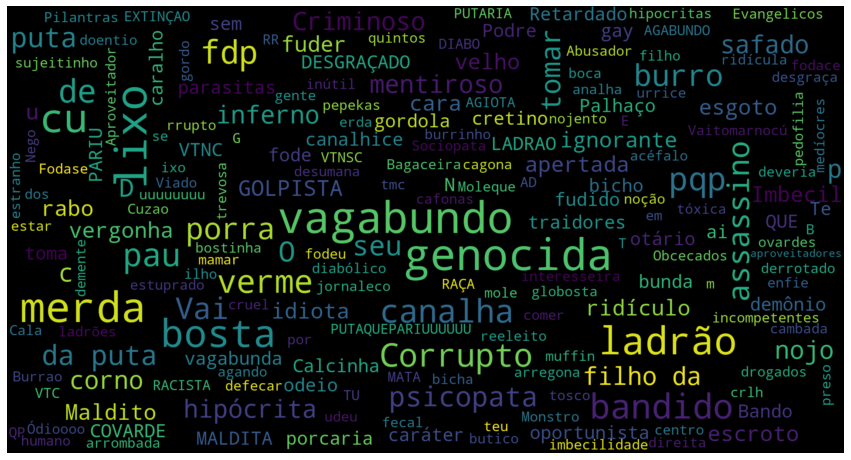

In [7]:
toxic_substrs = []

for row in df.to_dict(orient="records"):
    if row.get("toxic_spans") is not None:
        toxic_substrs.extend(get_toxic_substrings(row["text"], row["toxic_spans"]))

print(f"toxic_substrs: {len(toxic_substrs)}")

wc = WordCloud(width=1920, height=1024,
               max_words=200, max_font_size=100)

wc.generate(" ".join(toxic_substrs))

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [8]:
df = df[["text", "toxic_spans"]]

X = df["text"].values
y = df["toxic_spans"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=seed)

y_train = [get_toxic_substrings(x, y) for x, y in zip(X_train, y_train)]
y_train = [y[0] for y in y_train]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (198,)
X_test shape: (86,)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

(array([65., 44., 36., 18.,  8.,  6.,  3.,  5.,  4.,  9.]),
 array([  8. ,  36.1,  64.2,  92.3, 120.4, 148.5, 176.6, 204.7, 232.8,
        260.9, 289. ]),
 <BarContainer object of 10 artists>)

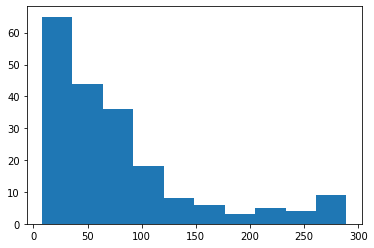

In [9]:
# Generate histogram of text (X_train) lengths
plt.hist([len(x) for x in X_train], bins=10)

In [61]:
import logging
import torch
import transformers
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
from sklearn.base import BaseEstimator
from keras.preprocessing.sequence import pad_sequences

tf.random.set_seed(params["seed"])
torch.manual_seed(params["seed"])

_logger = logging.getLogger(__name__)


class SpanCategorizer(BaseEstimator):
    def __init__(self, maxlen: int = 384, model_type: str = "bert",
                 model_name: str = "neuralmind/bert-base-portuguese-cased",
                 epochs: int = 3, batch_size: int = 32, learning_rate: float = 3e-5,
                 optimizer: str = "adam", validation_split: float = 0.2,
                 verbose: str = False):

        self.maxlen = maxlen
        self.model_type = model_type
        self.model_name = model_name
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.validation_split = validation_split
        self.verbose = verbose

        self.tokenizer = transformers.AutoTokenizer.from_pretrained(
            self.model_name, do_lower_case=True)

        _logger.debug("Initializing SpanCategorizer")

    def fit(self, X: List[str], y: List[List[int]]):

        _logger.debug("Fitting SpanCategorizer")

        input_ids, attention_mask, token_type_ids, start_tokens, end_tokens = self._preprocessing_train2(
            X, y)

        K.clear_session()
        model = self._build_model()

        model.fit(x=[input_ids, attention_mask, token_type_ids],
                  y=[start_tokens, end_tokens],
                  epochs=self.epochs, batch_size=self.batch_size,
                  verbose=1, validation_split=self.validation_split)

        _logger.debug("Fitted SpanCategorizer")

        self.model = model

    def _build_model(self):

        _logger.debug("Building SpanCategorizer model")

        ids = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)
        att = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)
        tok = tf.keras.layers.Input((self.maxlen,), dtype=tf.int32)

        if self.optimizer.lower() == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(
                learning_rate=self.learning_rate)
        elif self.optimizer.lower() == "adam":
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=self.learning_rate)
        else:
            raise ValueError(f"Optimizer {self.optimizer} not supported.")
            
        pretrained_model = transformers.AutoModelForMaskedLM.from_pretrained(
            self.model_name)

        x = pretrained_model(ids, attention_mask=att, token_type_ids=tok)

        x1 = tf.keras.layers.Dropout(0.1)(x[0])
        x1 = tf.keras.layers.Conv1D(128, 2, padding='same')(x1)
        x1 = tf.keras.layers.LeakyReLU()(x1)
        x1 = tf.keras.layers.Conv1D(64, 2, padding='same')(x1)
        x1 = tf.keras.layers.Dense(1)(x1)
        x1 = tf.keras.layers.Flatten()(x1)
        x1 = tf.keras.layers.Activation('softmax')(x1)

        x2 = tf.keras.layers.Dropout(0.1)(x[0])
        x2 = tf.keras.layers.Conv1D(128, 2, padding='same')(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
        x2 = tf.keras.layers.Dense(1)(x2)
        x2 = tf.keras.layers.Flatten()(x2)
        x2 = tf.keras.layers.Activation('softmax')(x2)

        model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1, x2])
        model.compile(loss="binary_crossentropy", optimizer=optimizer)

        _logger.debug("Built SpanCategorizer model")

        return model

    def _preprocessing_train2(self, X: List[str], Y: List[str]):
        "Developing"
        _logger.debug("Preprocessing SpanCategorizer")

        input_ids = []
        attention_mask = []
        token_type_ids = []
        start_tokens = []
        end_tokens = []

        for x, y in tqdm(zip(X, Y), total=len(X)):

            x = self.tokenizer(x, max_length=self.maxlen, truncation=True, return_tensors="pt")
            y = self.tokenizer(y, max_length=self.maxlen, truncation=True, return_tensors="pt")
            
            input_ids.append(x["input_ids"])
            attention_mask.append(x["attention_mask"])
            token_type_ids.append(x["token_type_ids"])

            start_tokens.append(y["input_ids"])
            end_tokens.append(y["attention_mask"])

        # Convert to pytorch tensors
        input_ids = torch.tensor(self.pad_sequences(input_ids))
        attention_mask = torch.tensor(self.pad_sequences(attention_mask))
        token_type_ids = torch.tensor(self.pad_sequences(token_type_ids))
        start_tokens = torch.tensor(self.pad_sequences(start_tokens))
        end_tokens = torch.tensor(self.pad_sequences(end_tokens))
        
        return input_ids, attention_mask, token_type_ids, start_tokens, end_tokens
        
    def pad_sequences(self, array: np.ndarray):
        lst = []

        for each in array:
            temp = pad_sequences(each,
                                 maxlen=self.maxlen,
                                 dtype="long",
                                 truncating="post",
                                 padding="post")

            lst.append(temp)
            
        return lst

    def _preprocessing_train(self, X: List[str], y: List[List[int]]):

        _logger.debug("Preprocessing SpanCategorizer training data")

        X_size = len(X)
        input_ids = np.ones((X_size, self.maxlen), dtype="int32")
        attention_mask = np.zeros((X_size, self.maxlen), dtype="int32")
        token_type_ids = np.zeros((X_size, self.maxlen), dtype="int32")
        start_tokens = np.zeros((X_size, self.maxlen), dtype="int32")
        end_tokens = np.zeros((X_size, self.maxlen), dtype="int32")

        for k in range(len(X)):
            text1 = " " + " ".join(X[k].split())
            text2 = " ".join(y[k].split())
            idx = text1.find(text2)
            chars = np.zeros((len(text1)))
            chars[idx:idx + len(text2)] = 1
            if text1[idx-1] == ' ':
                chars[idx-1] = 1

            enc = self.tokenizer.encode(text1)

            print(text1, enc)

            offsets = []
            idx = 0
            for t in enc:
                w = self.tokenizer.decode([t])
                offsets.append((idx, idx+len(w)))
                idx += len(w)

            toks = []
            for i, (a, b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm > 0:
                    toks.append(i)

            input_ids[k, :len(enc)+5] = [0] + enc + [2, 2] + [2, 2]
            attention_mask[k, :len(enc)+5] = 1

            if len(toks) > 0:
                start_tokens[k, toks[0]+1] = 1
                end_tokens[k, toks[-1]+1] = 1

        return input_ids, attention_mask, token_type_ids, start_tokens, end_tokens

    def _preprocessing_test(self, X: List[str]):

        _logger.debug("Preprocessing SpanCategorizer test data")

        X_size = len(X)
        input_ids = np.ones((X_size, self.maxlen), dtype="int32")
        attention_mask = np.zeros((X_size, self.maxlen), dtype="int32")
        token_type_ids = np.zeros((X_size, self.maxlen), dtype="int32")

        for k in range(len(X)):
            text1 = " "+" ".join(X[k].split())
            enc = self.tokenizer.encode(text1)

            input_ids[k, :len(enc)+5] = [0] + enc + [2, 2] + [2]
            attention_mask[k, :len(enc)+5] = 1

        return input_ids, attention_mask, token_type_ids

    def score(self, X_test: List[str], y_test: List[List[int]]):

        if self.model == None:
            raise AttributeError('The model is not trained yet.')

        preds = self.predict(X_test)

        scores = []

        for pred, true in zip(preds, y_test):
            score = self.jaccard(pred, true)
            scores.append(score)

        return np.mean(scores)

    def jaccard(self, str1: str, str2: str) -> float:
        """
        Calculate the Jaccard similarity between two strings.

        Args:
        - str1: the first string
        - str2: the second string

        Returns:
        - the Jaccard similarity between the two strings
        """
        a = set(str1.lower().split())
        b = set(str2.lower().split())
        c = a.intersection(b)

        try:
            jaccard_score = float(len(c)) / (len(a) + len(b) - len(c))
        except Exception as e:
            _logger.warning("An error occurred when compute jaccard score:", e)
            jaccard_score = float(0)
        finally:
            return jaccard_score

    def predict(self, X: List[str]) -> str:
        if self.model == None:
            raise AttributeError('The model is not trained yet.')

        input_ids, attention_mask, token_type_ids = self._preprocessing_test(X)

        preds = self.model.predict([input_ids, attention_mask, token_type_ids])

        selected_text = []
        for k in range(X.shape[0]):
            start = np.argmax(preds[0][k, ])
            end = np.argmax(preds[1][k, ])

            if start > end:
                text = X[k]
            else:
                text = " "+" ".join(X[k].split())
                enc = self.tokenizer.encode(text)
                text = self.tokenizer.decode(enc[start-1:end])

            selected_text.append(text)

        return selected_text

    def save_model(self, path: str):
        if self.model == None:
            raise AttributeError('The model is not trained yet.')
        tf.keras.models.save_model(self.model, path)

    def load_model(self, path: str, force: bool = False):
        if self.model != None and force == False:
            raise AttributeError(
                'You already have a loaded model. If you want to reload inform the parameter force=True')
        self.model = tf.keras.models.load_model(path)


In [62]:
spancat = SpanCategorizer()
spancat.fit(X_train, y_train)

100%|██████████| 198/198 [00:00<00:00, 4125.07it/s]
<ipython-input-61-330c56a0cbb5>:124: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_ids = torch.tensor(self.pad_sequences(input_ids))
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

AttributeError: 'KerasTensor' object has no attribute 'size'

In [56]:
input_ids, attention_mask, token_type_ids, start_tokens, end_tokens = spancat._preprocessing_train2(X_train, y_train)

100%|██████████| 198/198 [00:00<00:00, 1697.34it/s]


In [60]:
input_ids.shape

torch.Size([76032])

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

In [ ]:
print(classification_report(y_true, y_pred, digits=4,
                            target_names=classes.values()))

## Testing the model

In the last section, we will test the model with some comments from the test set.

In [ ]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred